# Project: Applied Machine Learning 
This notebook was created by Lennart Onghena, Roel Moeyersoons and Tim De Smet. 

This project is a collaboration with ML6. They are launching a product that automates parts of big email inboxes.

During `sprint 1` we decided to create a classifier that would be able to assign a general product class to the message of the customers. 

# 1. Exploratory Data Analysis (EDA)

First we need to explore the data in order to know what we are working with.


## 1.1. The Data

The features of the data are explained [here](https://cfpb.github.io/api/ccdb/fields.html) 

In [2]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import svm

%matplotlib inline

We first started out by creating a Google Colab notebook that used the csv that we stored into a Google Storage bucket. Because of the size of the file our team decided it would be easier for everyone to store the data locally and use a plain Jupyter notebook. 

First we need to read the data that we stored locally using the pandas library.

In [3]:
# Use pandas to read csv data into DataFrame
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

Usinge the .info() function the DataFrame we can determine the following about the data:
* There are a total of 485701 complaints
* There are a total of 18 features, one of which is numeric
* There are no missing values, so we don't have to eliminate these datapoints 

In [4]:
complaints.info()
# Example of a single datapoint
complaints.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485701 entries, 0 to 485700
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 485701 non-null  object
 1   Product                       485701 non-null  object
 2   Sub-product                   485701 non-null  object
 3   Issue                         485701 non-null  object
 4   Sub-issue                     485701 non-null  object
 5   Consumer complaint narrative  485701 non-null  object
 6   Company public response       485701 non-null  object
 7   Company                       485701 non-null  object
 8   State                         485701 non-null  object
 9   ZIP code                      485701 non-null  object
 10  Tags                          485701 non-null  object
 11  Consumer consent provided?    485701 non-null  object
 12  Submitted via                 485701 non-null  object
 13 

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/23/19,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,926XX,None,Consent provided,Web,07/23/19,Closed with explanation,Yes,NaN,3315279


First of all, let's check how many complains every product has received

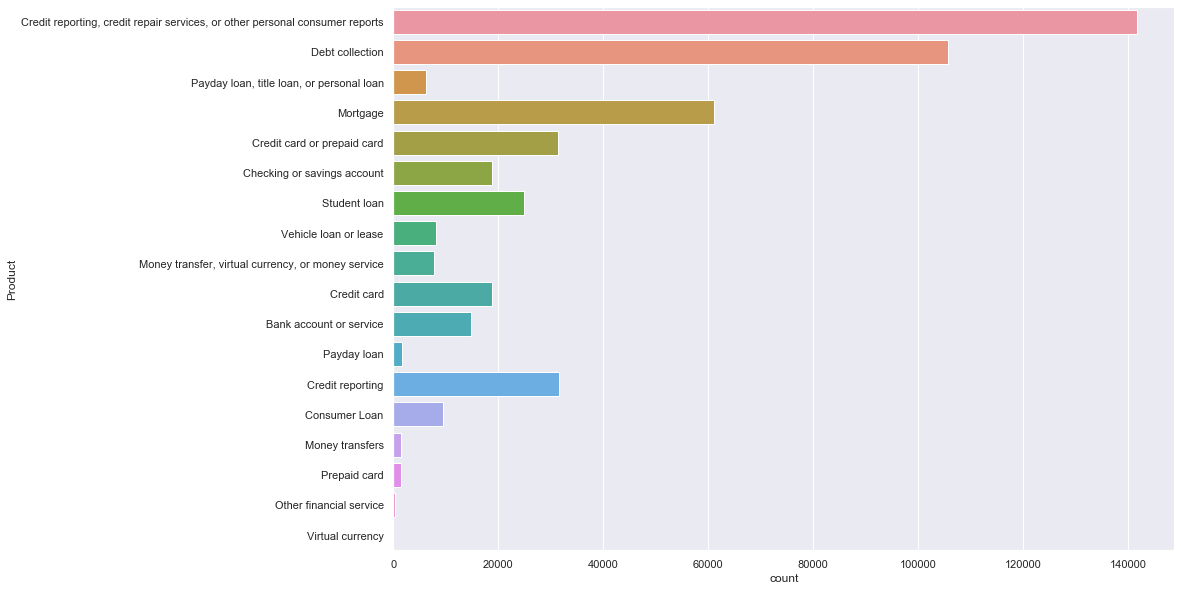

In [5]:
# Visual representation of the amount of complaints related to certain products
plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='Product', data=complaints)
plt.show()

The first thing we noticed was that this dataset is unbalanced. We adress this further in section 1.2. Problems.


These are the amount of complaints received about the different products and subproducts:

In [6]:
temp = complaints['Product'].value_counts();

for i in range(len(temp)):
    print(f'\n{temp.index[i]}: {temp[i]}')
    temp2 = (complaints[complaints['Product'] == temp.index[i]]['Sub-product'].value_counts())
    for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Credit reporting, credit repair services, or other personal consumer reports: 141742
		Credit reporting: 138534
		Other personal consumer report: 2481
		Credit repair services: 726
		Conventional home mortgage: 1

Debt collection: 105765
		I do not know: 20639
		Other debt: 18699
		Credit card debt: 14522
		Other (i.e. phone, health club, etc.): 12389
		Medical debt: 11239
		Credit card: 7520
		Medical: 6990
		Payday loan debt: 2461
		Auto debt: 2319
		Payday loan: 2064
		Mortgage debt: 1500
		Federal student loan debt: 1126
		Private student loan debt: 1093
		Auto: 1064
		Mortgage: 907
		Non-federal student loan: 684
		Federal student loan: 549

Mortgage: 61094
		Conventional home mortgage: 17063
		Conventional fixed mortgage: 14562
		FHA mortgage: 11341
		Conventional adjustable mortgage (ARM): 4975
		VA mortgage: 3437
		Other mortgage: 3236
		Home equity loan or line of credit: 2103
		Other type of mortgage: 2011
		Home equity loan or line of credit (HELOC): 1690
		Reverse mortgage

Let's look at the Product "Debt Collection" in particular:


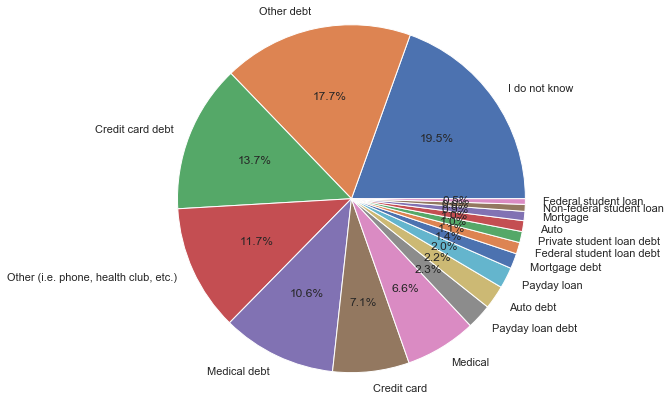

In [6]:
products = complaints["Product"].unique()

debt = complaints[complaints["Product"] == "Debt collection"]
subProdCount = debt["Sub-product"].value_counts()#[:10]

#plt.title("Debt Collection")
patches, texts, autotexts = plt.pie(subProdCount.values, labels = subProdCount.index, radius = 2, autopct="%.1f%%",)
for t in autotexts:
    t.set_fontsize(12)
plt.show()

To better see the distribution of Sub-Products, the above is also shown in pie plots.

We could have opted to use distribution plots (example: sns.distplot(...)) however due to the naming of the categories the visualisation in pie charts seemed more clear.

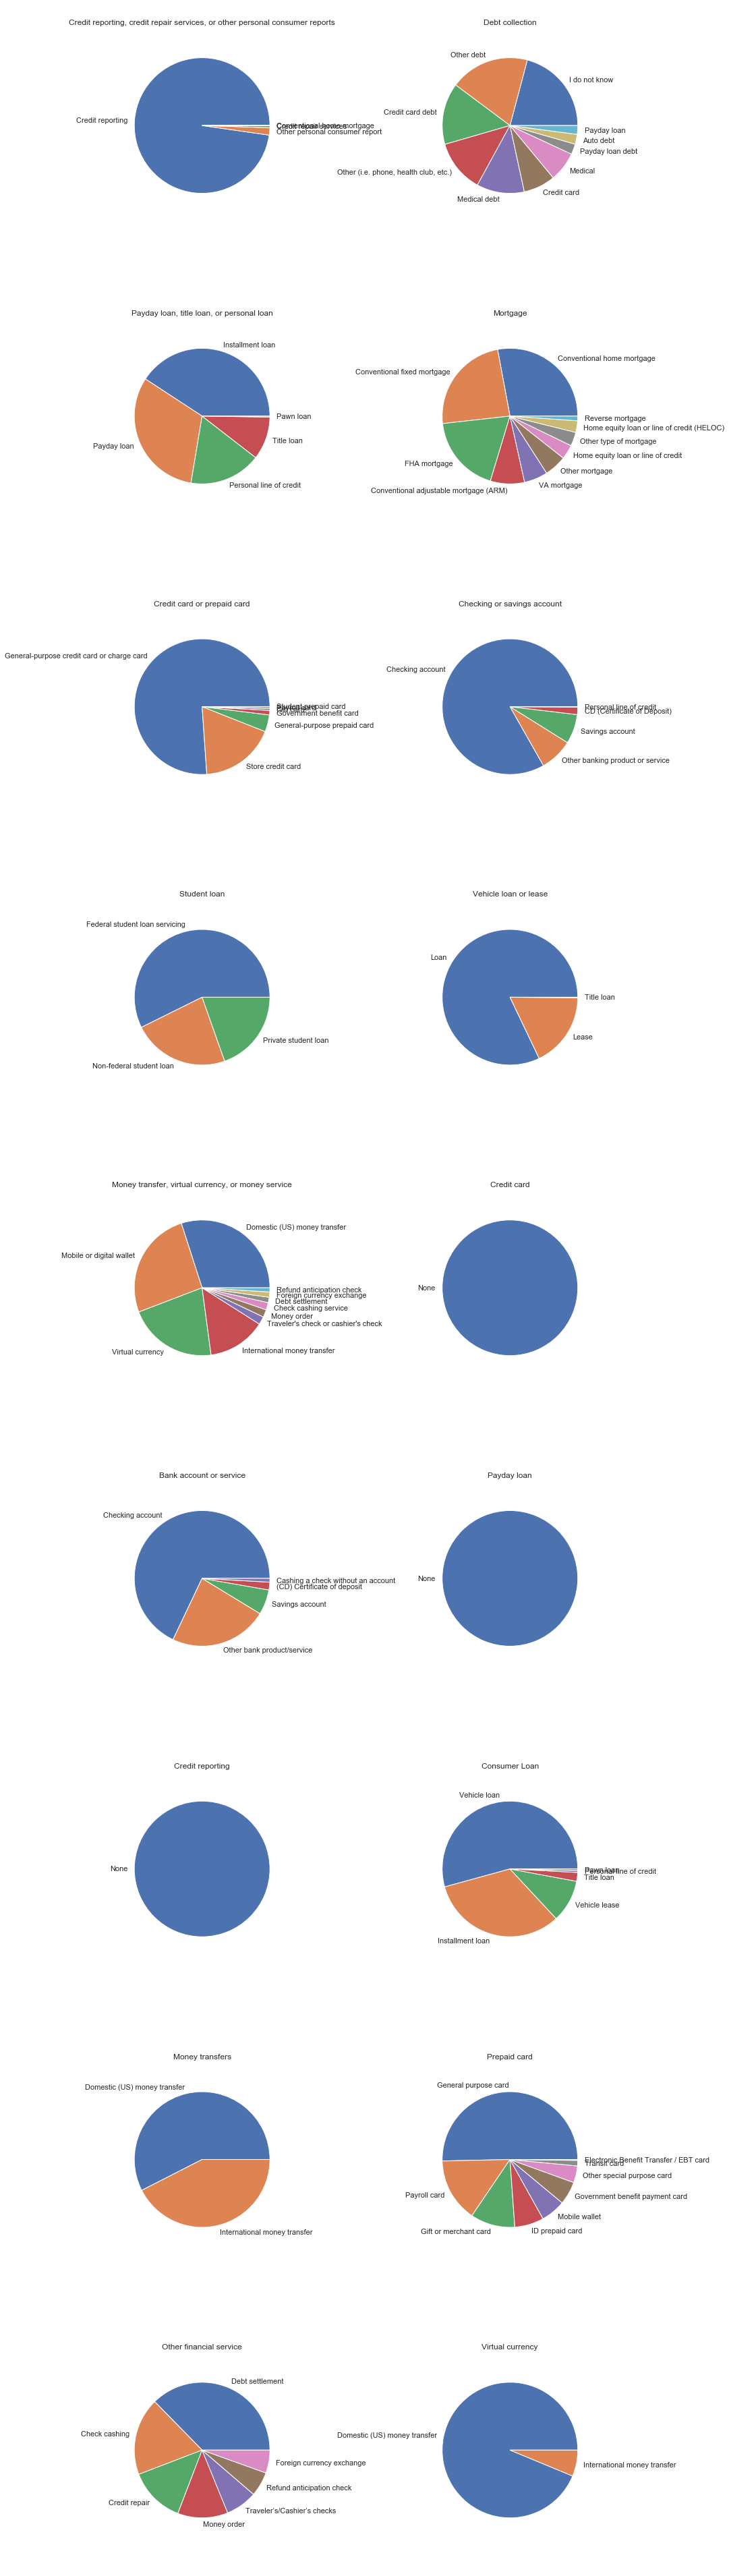

In [7]:
products = complaints["Product"].unique()
names = [x for x in products]

fig = plt.figure(figsize = (15,70))
#plt.rcParams.update({'font.size': 22})
#fig.subplots_adjust(hspace=0.1, wspace=0.3)
i = 0
for n in names:
    i = i + 1
    subplt = fig.add_subplot(9,2,i)
    subplt.set_title(n, y=0.9)
    x = complaints[complaints["Product"] == n]
    counts = x["Sub-product"].value_counts()[:10]
    plt.pie(counts.values, labels = counts.index, radius=0.7)
plt.show()

The distributions of the sub-issues for each issue are the following:

In [7]:
temp = complaints['Issue'].value_counts();

# to limit output: 
# for i in range 10:
# else 
for i in range(len(temp)):
    print(f'\n{temp.index[i]}: {temp[i]}')
    temp2 = (complaints[complaints['Issue'] == temp.index[i]]['Sub-issue'].value_counts())
    for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Incorrect information on your report: 77776
		Information belongs to someone else: 32324
		Account status incorrect: 15559
		Account information incorrect: 15060
		Old information reappears or never goes away: 4282
		Personal information incorrect: 4058
		Public record information inaccurate: 3900
		Information is missing that should be on the report: 1726
		None: 512
		Information is incorrect: 298
		Information that should be on the report is missing: 57

Problem with a credit reporting company's investigation into an existing problem: 38424
		Their investigation did not fix an error on your report: 27394
		Investigation took more than 30 days: 3027
		Difficulty submitting a dispute or getting information about a dispute over the phone: 2877
		Was not notified of investigation status or results: 2616
		Problem with personal statement of dispute: 2317
		None: 193

Attempts to collect debt not owed: 28629
		Debt is not yours: 14708
		Debt was paid: 6413
		Debt was result of identity t

Let's visualize the issues by product:

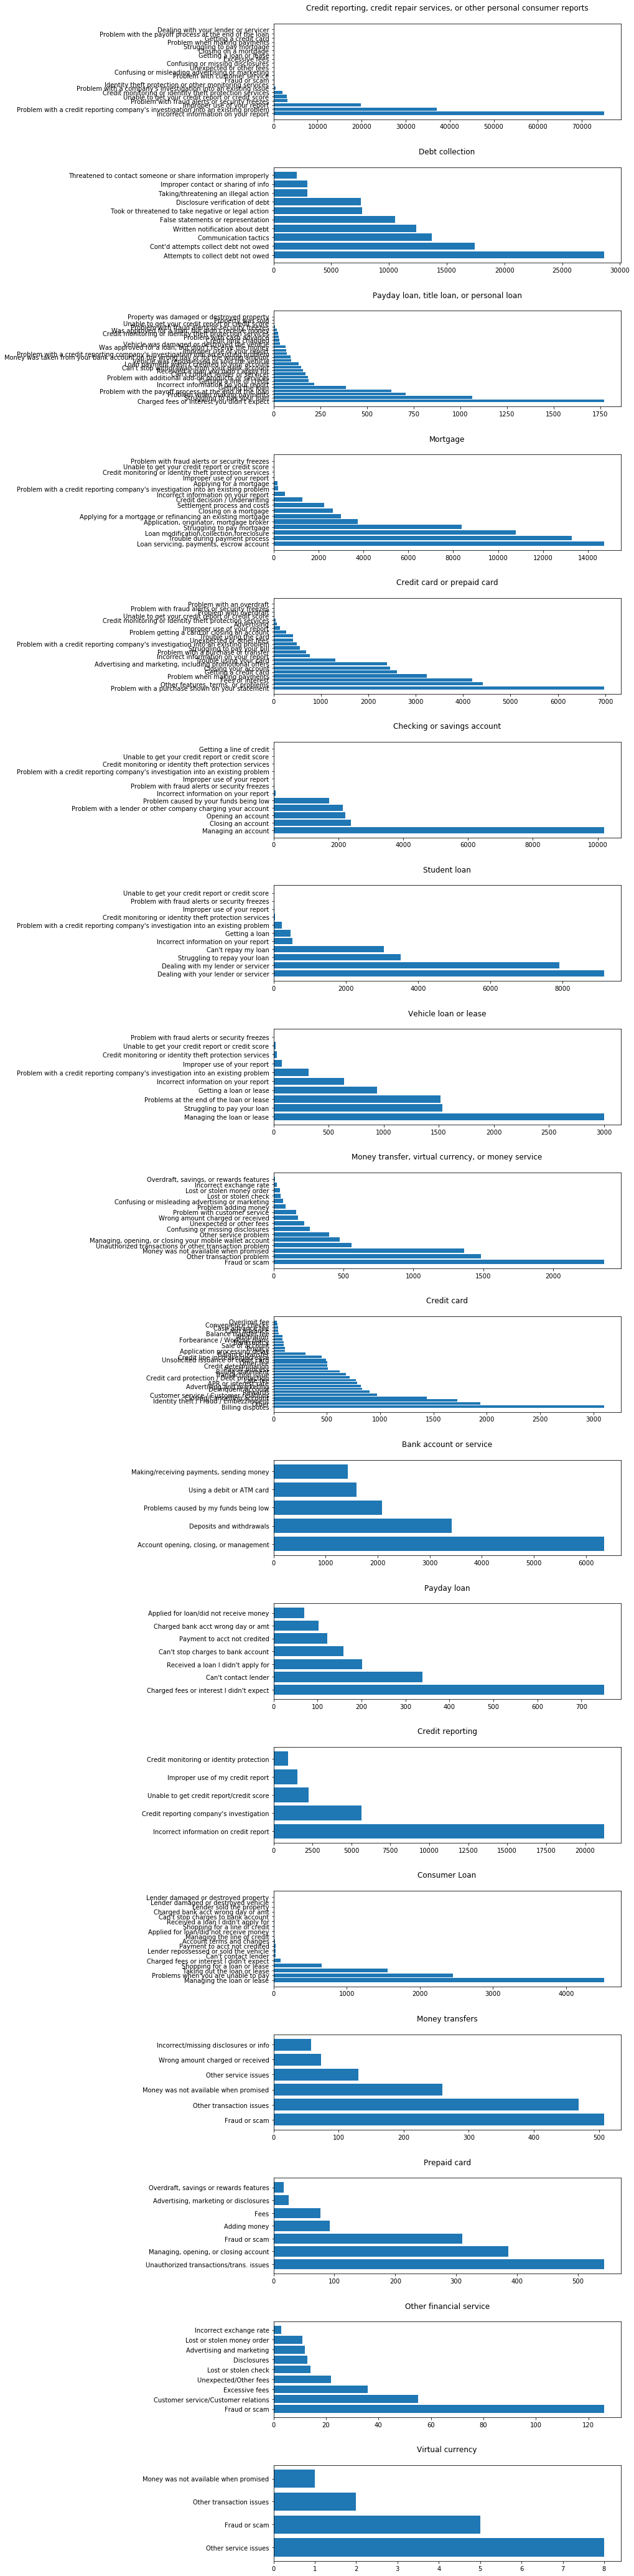

In [3]:
products = complaints["Product"].unique()
names = [x for x in products]

fig = plt.figure(figsize = (10,75))
#plt.rcParams.update({'font.size': 26})
fig.subplots_adjust(hspace=0.5)
i = 0
for n in names:
    i = i + 1
    ax = fig.add_subplot(18,1,i)
    ax.set_title(n, y=1.1)
    x = complaints[complaints["Product"] == n]
    counts = x["Issue"].value_counts()

    y_pos = np.arange(len(counts))
    ax.barh(y_pos, counts.values, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(counts.index)
    
plt.show()

As seen above, some issues appear in several products. Below the issues are printed along with each product category it appears in

In [9]:
temp = complaints['Issue'].value_counts();

for i in range(len(temp)):
    
    temp2 = (complaints[complaints['Issue'] == temp.index[i]]['Product'].value_counts())
    if len(temp2) > 1:
        print(f'\n{temp.index[i]}: {temp[i]}')
        for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Incorrect information on your report: 77776
		Credit reporting, credit repair services, or other personal consumer reports: 75050
		Credit card or prepaid card: 761
		Vehicle loan or lease: 639
		Student loan: 531
		Mortgage: 511
		Payday loan, title loan, or personal loan: 219
		Checking or savings account: 65

Problem with a credit reporting company's investigation into an existing problem: 38424
		Credit reporting, credit repair services, or other personal consumer reports: 37107
		Credit card or prepaid card: 496
		Vehicle loan or lease: 317
		Student loan: 223
		Mortgage: 193
		Payday loan, title loan, or personal loan: 72
		Checking or savings account: 16

Improper use of your report: 20239
		Credit reporting, credit repair services, or other personal consumer reports: 19878
		Credit card or prepaid card: 132
		Vehicle loan or lease: 74
		Payday loan, title loan, or personal loan: 67
		Mortgage: 50
		Student loan: 21
		Checking or savings account: 17

Dealing with your lender or

## 1.2. Problems

* Sub-product and Sub-issue not always present
* Product columns are overlapping, we could change to:        
    * Mortgage (cat A)
    * Loan (cat B)
        * Consumer Loan
        * Payday loan
        * Payday loan, title loan, or personal loan
        * Student loan
        * Vehicle loan or lease
    * Card (cat C)
        * Credit card
        * Credit card or prepaid card
        * Prepaid card
    * Credit (cat D)
        * Credit reporting
        * Credit reporting, credit repair services, or other personal consumer reports
    * Other financial service (cat E)
        * Money transfer, virtual currency, or money service
        * Money transfers
        * Virtual currency
        * Bank account or service
        * Checking or savings account
    * Debt collection (cat F)
* Also overlap between issues 
* Some Products have the same issue names

# DIT MAG GERUST WEG VAN MIJ (OF GEUPDATED WORDEN)
In the first iteration we are going to
* remove seemingly unnecessairy data and simplify dataset
* Extract features
* One hot encoding for categorical features
* remove imbalances
* pairplot
* catplot
* train test split

* Classify incoming messages to some basic issue types

## 1.3. Simplification

In order to achieve what we wanted we decided to simplify the possible product categories due to the overlap.

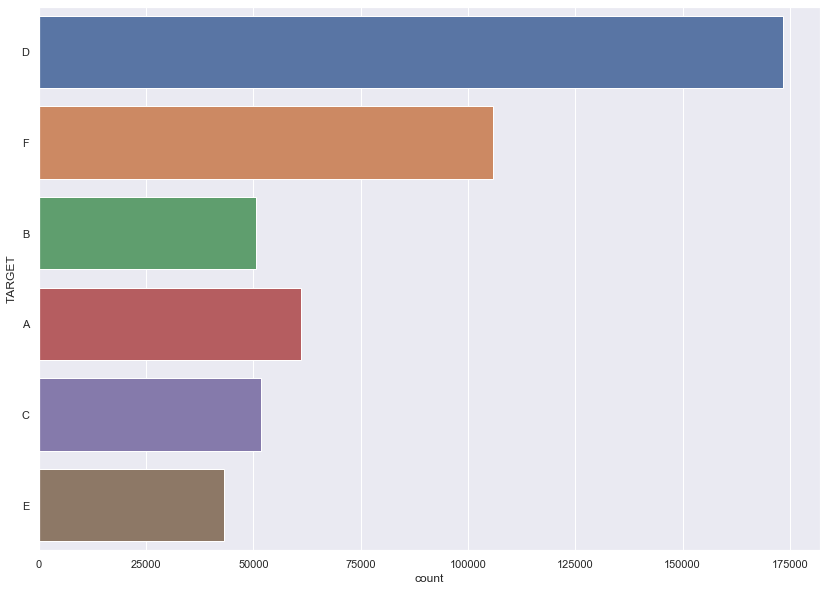

In [12]:
# simplifying dataset
simp_map = {
    'Debt collection' : 'F', 
    'Payday loan' : 'B', 
    'Mortgage' : 'A', 
    'Bank account or service' : 'E', 
    'Consumer Loan' : 'B', 
    'Other financial service' : 'E', 
    'Vehicle loan or lease' : 'B',
    'Payday loan, title loan, or personal loan' : 'B', 
    'Money transfers' : 'E', 
    'Student loan' : 'B', 
    'Virtual currency': 'E', 
    'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
    'Credit card' : 'C', 
    'Checking or savings account' : 'E', 
    'Prepaid card' : 'C', 
    'Money transfer, virtual currency, or money service' : 'E', 
    'Credit reporting': 'D', 
    'Credit card or prepaid card' : 'C'}

featureSet = complaints[['Product', 'Consumer complaint narrative']].copy()
featureSet['TARGET'] = featureSet['Product'].map(simp_map)

plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=featureSet)
plt.show()

We can see that the dataset is imbalanced, this could cause the model to collapse to the trivial solution of always returning the same prediction. We will resolve this by subsampling in order to flatten the distribution. 

# WE ZOUDEN HIER OOK KUNNEN OPTEREN VAN GEWICHTEN TOE TE KENNEN AAN ONS MODEL. MISSCHIEN KUNNEN WE DIT OOK NOG PROBEREN

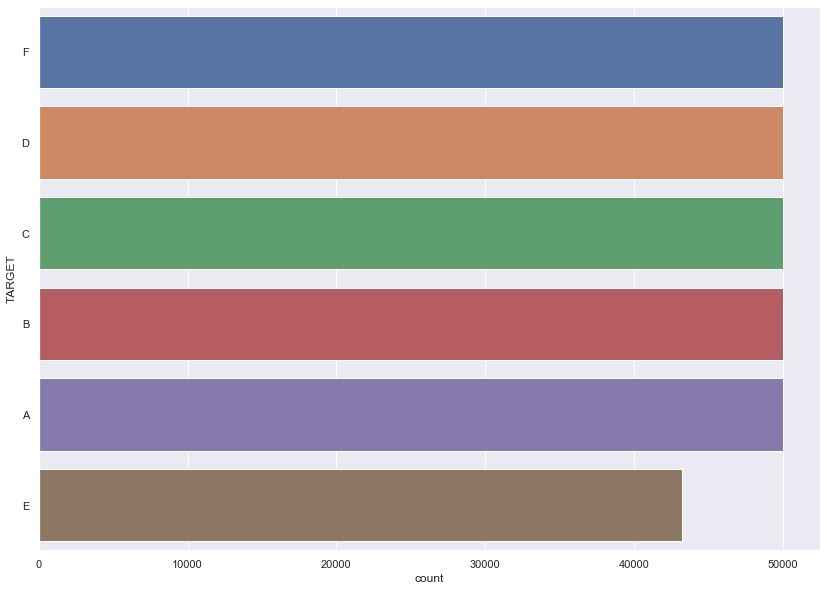

In [13]:
for c in ['A', 'B', 'C', 'D', 'E', 'F']:
    if featureSet[featureSet['TARGET'] == c].shape[0] > 50000:
        featureSet = pd.concat(objs=[featureSet[featureSet['TARGET'] == c].sample(n=50000), featureSet[featureSet['TARGET'] != c]])

plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=featureSet)
plt.show()

Let's now take a sample from this set that shall be used further during the project. The size of the subsample is very important. Too little and your model might be overtuned to some texts, while being undertuned to others. 

The bigger the subsample the more accurate your model will be for the whole dataset. However, in order to not overburden our CPU's, we limit it during the project to 15000. 

A fixed seed is also added so that the same sample is produced every time. Needless to say this can lead to exploits where the model performs very well for this one sample. This is not our intention, the only reason the seed given below is used is because it gives an equalish amount of rows for every target. 

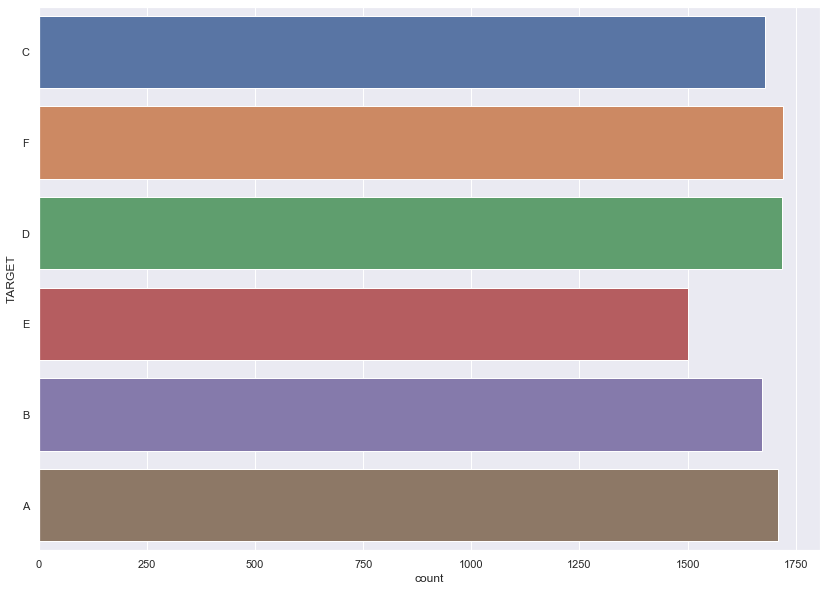

In [33]:
data = featureSet.sample(10000,random_state=7844569)
plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=data)
plt.show()

## 1.4. Feature extraction and behind the scene preprocessing

We need to extract features from the messages. 

We chose TF-IDF for its normalization features. We remembered: "A word that occurs often in a certain document but does not occur often in other documents is probably an important word for this document."

# HIER KUNNEN WE NOG WORD2VEC PROBEREN

In [34]:
%%time

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data['Consumer complaint narrative'])
print(X_train_counts.shape)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(10000, 21153)
(10000, 21153)
Wall time: 1.82 s


## 1.5. Dimensionality Reduction
The tfidf vector is too large to work with. The train_test_split overflowed the memory because of .todense() function.

The first thing we tried was PCA but here too the memory overflowed and interrupted the kernel. However we came upon TruncatedSVD:
[source](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
>In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

Hyperparameter 100 was chosen because this is what the document recommends for LSA.

In [35]:
%%time
svd = TruncatedSVD(n_components=100)
tfidf_reduced = svd.fit_transform(X_train_tfidf)
print(tfidf_reduced.shape)
print(type(tfidf_reduced))

(10000, 100)
<class 'numpy.ndarray'>
Wall time: 2.11 s


## 1.6. Train Test Split

In order to make sure we have data left that the model has never seen before we split the data.

In [36]:
%%time
y = data['TARGET']
x = tfidf_reduced
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)
#print(x_train.shape)

Wall time: 10 ms


## 1.7. K-nearest neighbors

This is the first classifier we decided to try.

In [37]:
%%time
#%%script false --no-raise-error

knn = KNeighborsClassifier(algorithm='kd_tree')
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)
(predictions == y_test).mean()

Wall time: 4.15 s


0.653

By selecting different samples, we get an accuracy of about 65% with standard Knn

### 1.7.1. Hyper Parameter Tuning (K)

The amount of nearest neighbours can be tuned in order to pinpoint a good value. We did this by plotting the accuracy for different values.

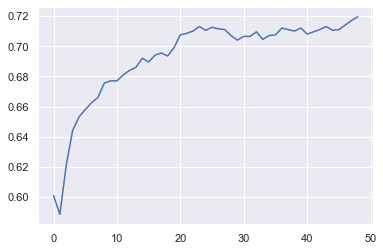

Wall time: 3min 39s


In [38]:
%%time
#%%script false --no-raise-error

accuracies = []
for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    accuracies.append((predictions == y_test).mean())
plt.plot(accuracies)
plt.show()

For this sample, the graph showed us that 15 would be a more appropriate value for k instead of the default of 5. 

The score for this model is: 0.703
CPU times: user 2 s, sys: 11.7 ms, total: 2.01 s
Wall time: 2.01 s


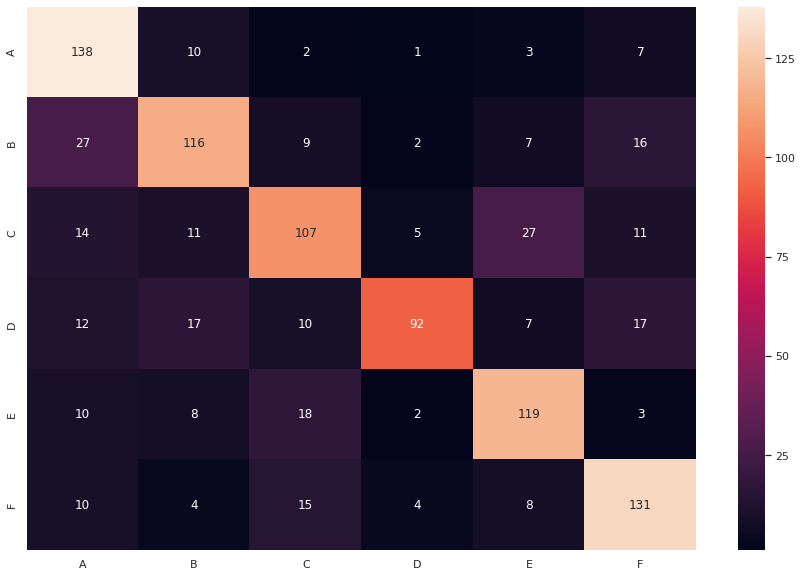

In [111]:
%%time
#%%script false --no-raise-error

knn = KNeighborsClassifier(n_neighbors=15, algorithm='kd_tree')
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)
cm = confusion_matrix(y_test, predictions)

print(f'The score for this model is: {knn.score(x_test, y_test)}')
labels = ['A', 'B', 'C', 'D', 'E', 'F']

fig = plt.figure(figsize = (15,10))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)

We could delve deeper into the hyperparameters and use GridSearchCV. That tool calculates the correct hyperparameters for you by doing an exhausive grid search. It is also useful for cross-validation, which we didn't check here. With cross-validation, different training and test sets are used in orde to make sure the same hyperparameters perform well with different data. GridSearchCV might be used later on in order to always find the best hyperparameters. 

This model has about 70% accuracy. Not bad considering a random classifier with 6 classes has 16,6% accuracy (the perfect one 100%). However we decided we wanted to check if logistic regression does a better job at this task.


## 1.8 Logistic Regression

In [40]:
%%time
#%%script false --no-raise-error
lr = LogisticRegression(random_state=0, multi_class='auto', max_iter=1000)
lr.fit(x_train, y_train)

print(lr.score(x_test, y_test))

0.814
Wall time: 531 ms


This model has about 80% accuracy. We improved our model by 10% by simply using a different classifier algorithm. But in order to achieve better results we decided to tune de hyperparameters even further.

### 1.8.1 (better) hyperparameter tuning

Let's now use GridSearchCV in order to find good hyperparameters. We will also validate the model / tune it even better by using cross-validation. Here 5 folds are used.

The hyperparameters for logistic regression can be found at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. 

In [132]:
from sklearn.model_selection import GridSearchCV

paramGrid = {'C': [0.1, 1, 10, 100, 1000, 10000],  'solver' : ['newton-cg', 'liblinear']}

search = GridSearchCV(estimator=lr, param_grid=paramGrid, cv=5)
search.fit(x_train,y_train)#? ipv x_train ect
print(search.best_params_)

{'C': 10, 'solver': 'liblinear'}


To no one's surprise the best solver is liblinear as the docs state it performs better but is slower contrary to other solvers.

In [133]:
model = search.best_estimator_
predictions = model.predict(x_test)
(predictions == y_test).mean()

0.811

With the best cosen parameters from the grid, an accuracy of 81% is achieved. In fac tthis is even worse than with the default parameters that lr uses. This means that either the param grid is poorly chosen, or that the the default parameters were really close to a (local/global) minimum. Different parameters should be analysed and/or what values they can be.

## 1.9. Support Vector Machines

We tried another classifier for good measure. 

### 1.9.1 Linear

In [118]:
%%time
#%%script false --no-raise-error
lin_svm = svm.LinearSVC()
lin_svm.fit(x_train, y_train)
print(lin_svm.score(x_test, y_test))

0.807
CPU times: user 328 ms, sys: 4.46 ms, total: 333 ms
Wall time: 318 ms


### 1.9.2. Non-linear SVM

The generates the same result as the example above, but it takes longer.

In [120]:
%%time
#%%script false --no-raise-error

nlin_svm = svm.NuSVC(gamma='auto')
nlin_svm.fit(x_train, y_train)
print(nlin_svm.score(x_test, y_test))

0.799
CPU times: user 3.25 s, sys: 4.09 ms, total: 3.26 s
Wall time: 3.26 s


## 1.10. Hyperparameter tuning (automatisch)

# DIT MOETEN WE NOG DOEN AAN DE HAND VAN PIPELINES

# TODOS:

* Opmerking bij 1.2. verwerken
* 1.3. Weighted model?
* 1.4. Word2Vec?
* 1.6. k-fold cross validation?
* 1.10. Hyperparameter tuning: Pipelines toevoegen
* Overal meer uitleg over onze veronderstellingen neerschrijven en staven wat we waarom hebben gedaan
* Tabel maken van wie wat gedaan heeft